In [2]:
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, WhiteKernel, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor

In [3]:
# %% Visualize some predictions
def plot_truth_vs_prediction(truth, prediction, x):
    plt.figure(figsize=(12, 5))
    plt.plot(x, truth, label='Truth', color='blue')
    plt.plot(x, prediction, label='Prediction', color='red', linestyle='--')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('Truth vs Prediction')
    plt.legend()
    plt.grid()
    plt.show()

# Darcy equation




## Load and plot the data

In [29]:
folder = "data/burgers/"

# data = np.load(folder + "burgers_gp_dataset_0.5.npz")
# data_single = np.load(folder + "burgers_1d_demo_data.npz")
# print(data.keys())

from scipy.io import loadmat

data = loadmat(folder + "burgers_data_R10.mat")

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'a', 'a_smooth', 'a_smooth_x', 'a_x', 'u'])


In [30]:
u0 = data['a']  # shape (N_samples, N_space)
uT  = data['u']  # shape (N_samples, N_space)

In [31]:
data['a'].shape

(2048, 8192)

In [32]:
x = np.linspace(0, 1, u0.shape[1])
downsample_factor = 2 ** 6
x = x[::downsample_factor]
u0 = u0[:, ::downsample_factor]
uT = uT[:, ::downsample_factor]

In [33]:
N = u0.shape[0]
n_train = int(0.8 * N)
u0_train = u0[:n_train,:]
uT_train = uT[:n_train,:]
u0_test = u0[n_train:,:]
uT_test = uT[n_train:,:]
print(u0_train.shape, uT_train.shape, u0_test.shape, uT_test.shape)

(1638, 128) (1638, 128) (410, 128) (410, 128)


## Input/output plot

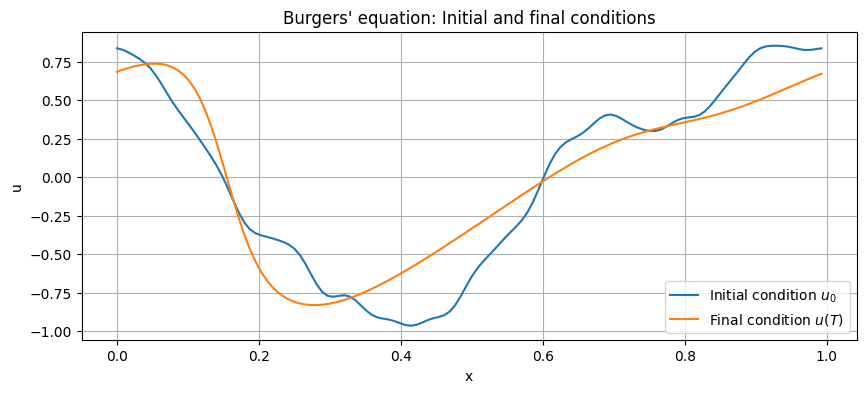

In [34]:
# Plot a an initial and final condition from the dataset
idx = 0
plt.figure(figsize=(10,4))
plt.plot(x, u0[idx], label='Initial condition $u_0$')
plt.plot(x, uT[idx], label='Final condition $u(T)$')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Burgers\' equation: Initial and final conditions')
plt.legend()
plt.grid()
plt.show()

# Encoder-Decoder

## Input

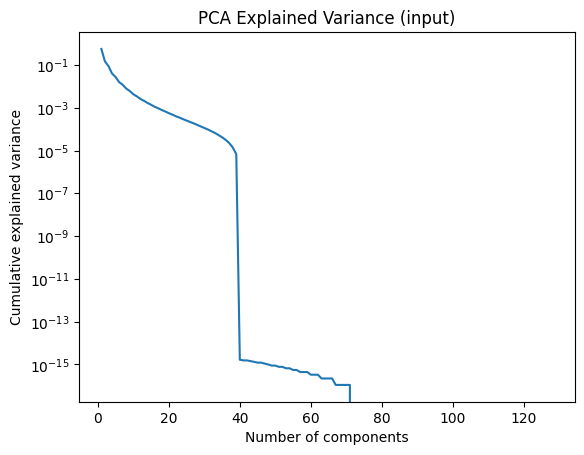

In [35]:
#%% first look at the pca on the input data
n_input = int(jnp.min(jnp.array(u0_train.shape)))
pca_input = PCA(n_components=n_input)
pca_input.fit(u0_train)
variance_input = pca_input.explained_variance_ratio_
plt.plot(jnp.arange(n_input) + 1, 1- jnp.cumsum(pca_input.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA Explained Variance (input)')
plt.yscale("log")

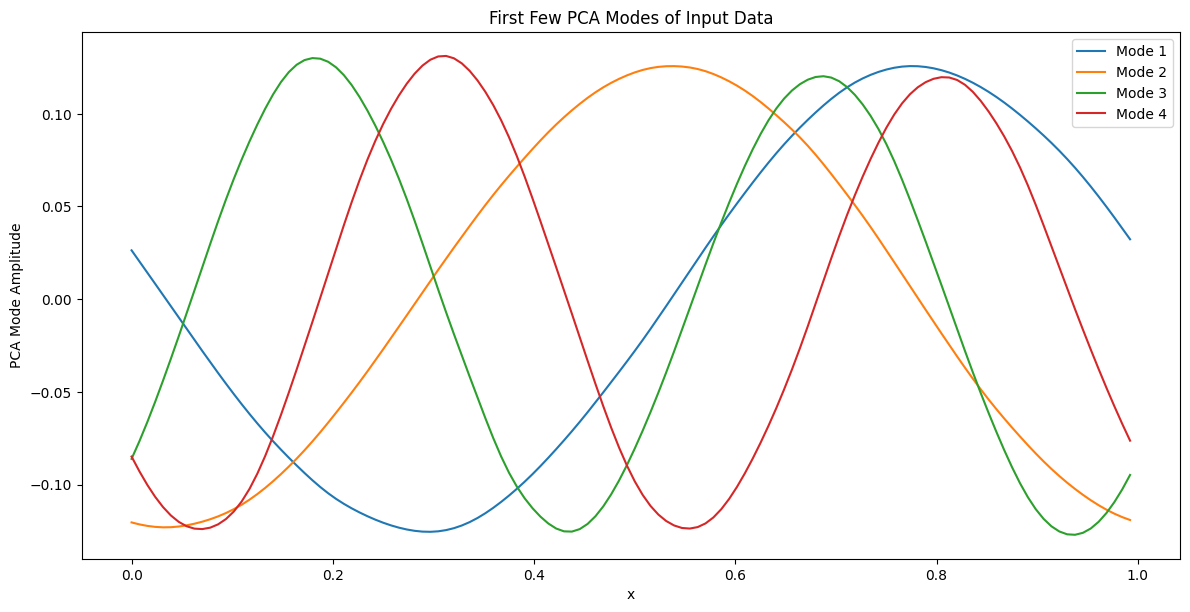

In [36]:
# Plot the first few PCA modes for the input
num_modes_to_plot = 4
components = pca_input.components_
plt.figure(figsize=(12, 6))
for i in range(num_modes_to_plot):
    mode = components[i]
    plt.plot(x, mode, label=f'Mode {i+1}')
    plt.xlabel('x')
    plt.ylabel('PCA Mode Amplitude')
plt.tight_layout()
plt.title('First Few PCA Modes of Input Data')
plt.legend()
plt.show()

## Output

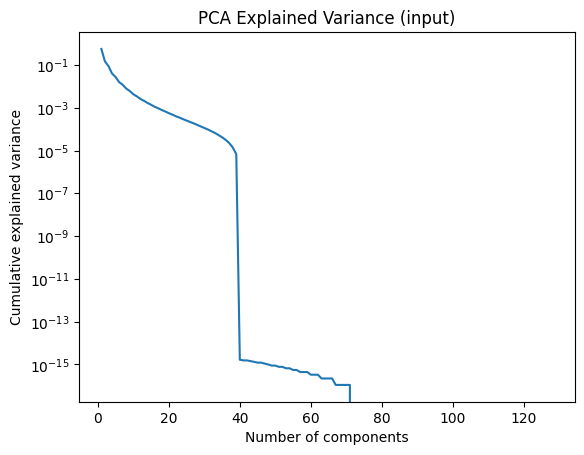

In [37]:
#%% first look at the pca on the input data
n_input = int(jnp.min(jnp.array(uT_train.shape)))
pca_output = PCA(n_components=n_input)
pca_output.fit(uT_train)
variance_input = pca_input.explained_variance_ratio_
plt.plot(jnp.arange(n_input) + 1, 1- jnp.cumsum(pca_input.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA Explained Variance (input)')
plt.yscale("log")

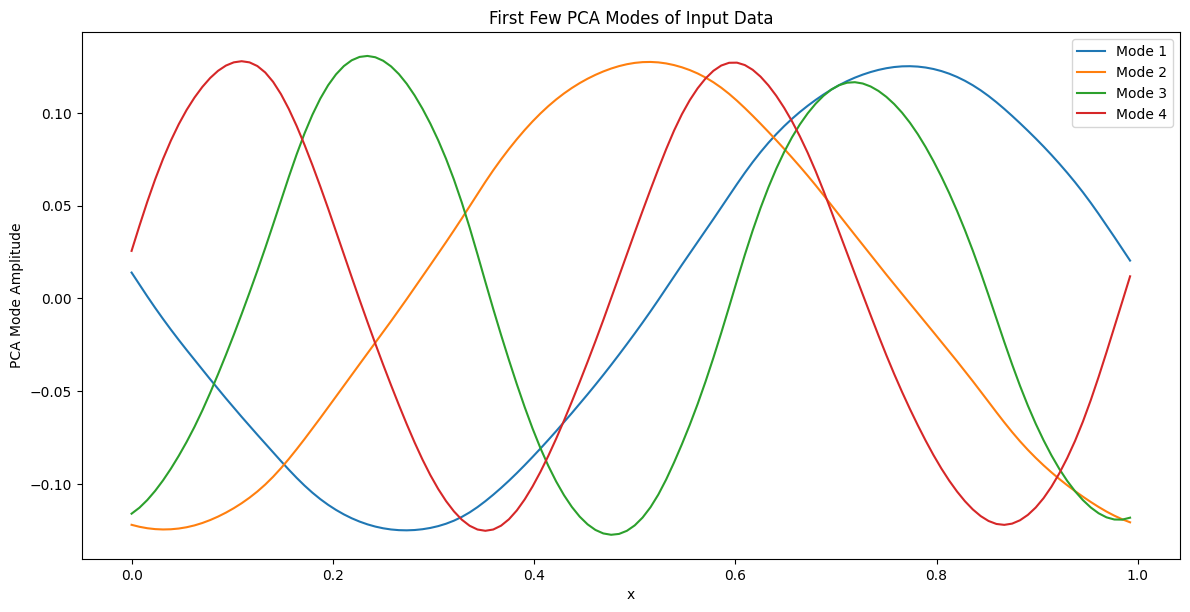

In [38]:
# Plot the first few PCA modes for the input
num_modes_to_plot = 4
components = pca_output.components_
plt.figure(figsize=(12, 6))
for i in range(num_modes_to_plot):
    mode = components[i]
    plt.plot(x, mode, label=f'Mode {i+1}')
    plt.xlabel('x')
    plt.ylabel('PCA Mode Amplitude')
plt.tight_layout()
plt.title('First Few PCA Modes of Input Data')
plt.legend()
plt.show()

# Build a operator 

In [39]:
# Define the encoders
pca_input = PCA(n_components=20)
pca_output = PCA(n_components=20)

u0_train_pca = pca_input.fit_transform(u0_train)
uT_train_pca = pca_output.fit_transform(uT_train)


In [40]:
kernel = ConstantKernel()*Matern(length_scale=1.0, nu=1.5) + WhiteKernel(noise_level=1.0)

f = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-10, # generally this can be low because noise is very low
    normalize_y=True,
) # or some other model you like

f.fit(u0_train_pca, uT_train_pca)

/opt/anaconda3/envs/jax-cpu/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,1**2 * Matern...noise_level=1)
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,0
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,None
,kernel__k1,"1**2 * Matern...ale=1, nu=1.5)"
,kernel__k2,WhiteKernel(noise_level=1)
,kernel__k1__k1,1**2


In [41]:
# Predict on test data
u0_test_pca = pca_input.transform(u0_test) # encode
uT_test_pca = f.predict(u0_test_pca) # predict 
pred_test = pca_output.inverse_transform(uT_test_pca) # decode
test_error = jnp.linalg.norm(uT_test - pred_test) / jnp.linalg.norm(uT_test)
print("Test relative L2 error: ", test_error)

Test relative L2 error:  0.04091543773109654


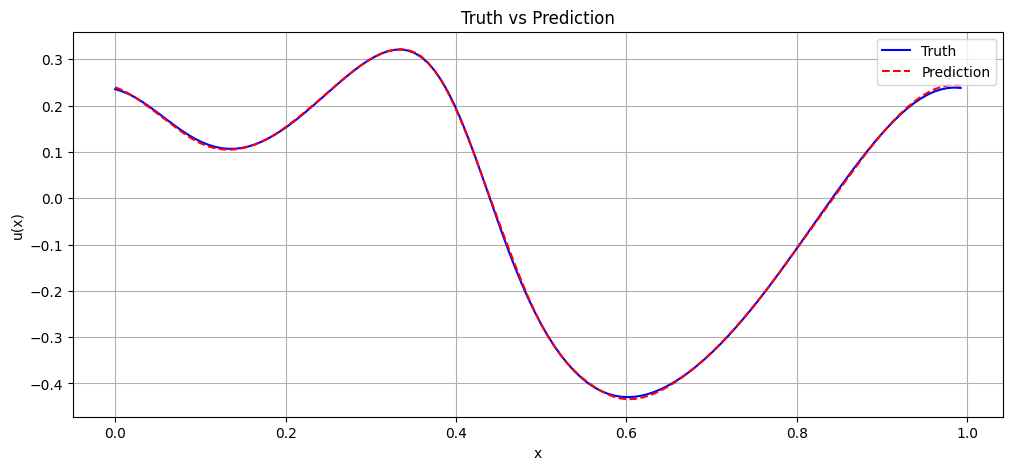

In [42]:
# Plot a prediction
idx = 0  # index of the test sample to plot
plot_truth_vs_prediction(uT_test[idx,:], pred_test[idx,:], x)

# Uncertainty quantification

$$
f(u_i) \in \mathbb{R}^n \sim \mathcal{N}(\mu, \bold{C})
$$
The reconstruction operator $\chi(f(u_i)) = W^\intercal f(u_i)$ which implies that 

$$
\chi(f(u_i)) \sim \mathcal{N}(W^\intercal \mu, W^\intercal\bold{C}W)
$$

(note that in this case $\bold{C}$ is diagonal)

In [43]:
idx = -1
u0_test_pca = pca_input.transform(u0_test[idx].reshape(1, -1)) # encode
mean, std = f.predict(u0_test_pca, return_std = True) # predict 

mean_decoded =pca_output.components_.T @ mean.T + pca_output.mean_[:, np.newaxis]
std_decoded = jnp.sqrt(jnp.diag(pca_output.components_.T @ jnp.diag(std[0]**2) @ pca_output.components_))

uppper = mean_decoded.flatten() +  std_decoded
lower = mean_decoded.flatten() - std_decoded

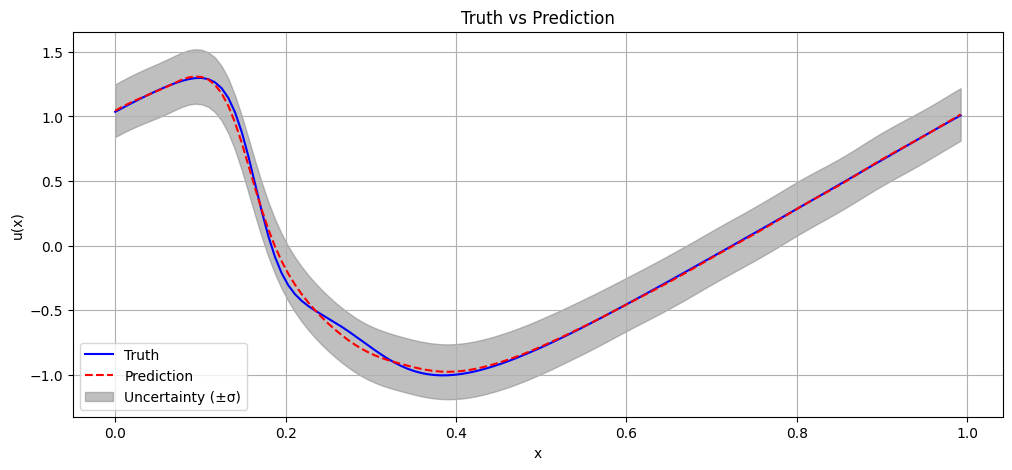

In [44]:
plt.figure(figsize=(12, 5))
plt.plot(x, uT_test[idx], label='Truth', color='blue')
plt.plot(x, mean_decoded, label='Prediction', color='red', linestyle='--')
plt.fill_between(x, lower, uppper, color='gray', alpha=0.5, label='Uncertainty (±σ)')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Truth vs Prediction')
plt.legend()
plt.grid()
plt.show()